In [1]:
import pandas as pd
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
from shapely.ops import unary_union
from shapely.geometry import Polygon
from geovoronoi.plotting import subplot_for_map, plot_voronoi_polys_with_points_in_area
from geovoronoi import voronoi_regions_from_coords, points_to_coords

df = pd.read_csv("data/Location_of_warehouses_Bangalore.csv")
# these two are way outside the city
df = df[df['Sl.no'].apply(lambda x: x not in {45, 46})].reset_index(drop=True).drop(columns='Sl.no', axis=1)
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(
        df['Longitude (E) (in degrees)'], df['Latitude (N) (in degrees)']),
)
df

,Wholesalers,Latitude (N) (in degrees),Longitude (E) (in degrees),geometry
0,Aravind Onion Traders,12.918900,77.592800,POINT (77.59280 12.91890)
1,R K Traders,12.914690,77.572750,POINT (77.57275 12.91469)
2,Rudreswara Traders,13.106670,77.445300,POINT (77.44530 13.10667)
3,Kk Traders,12.964380,77.580300,POINT (77.58030 12.96438)
4,RIZ Traders,12.916190,77.573090,POINT (77.57309 12.91619)
5,Sri Lakshmi Venkateshwara Prasanna Onion Shop,12.905980,77.624250,POINT (77.62425 12.90598)
6,City Market,12.922220,77.573090,POINT (77.57309 12.92222)
7,KBB Onion Shop,13.008560,77.635470,POINT (77.63547 13.00856)
8,Onion Shop,13.035280,77.564600,POINT (77.56460 13.03528)
9,Yeshwanthpur Market,13.021040,77.554030,POINT (77.55403 13.02104)


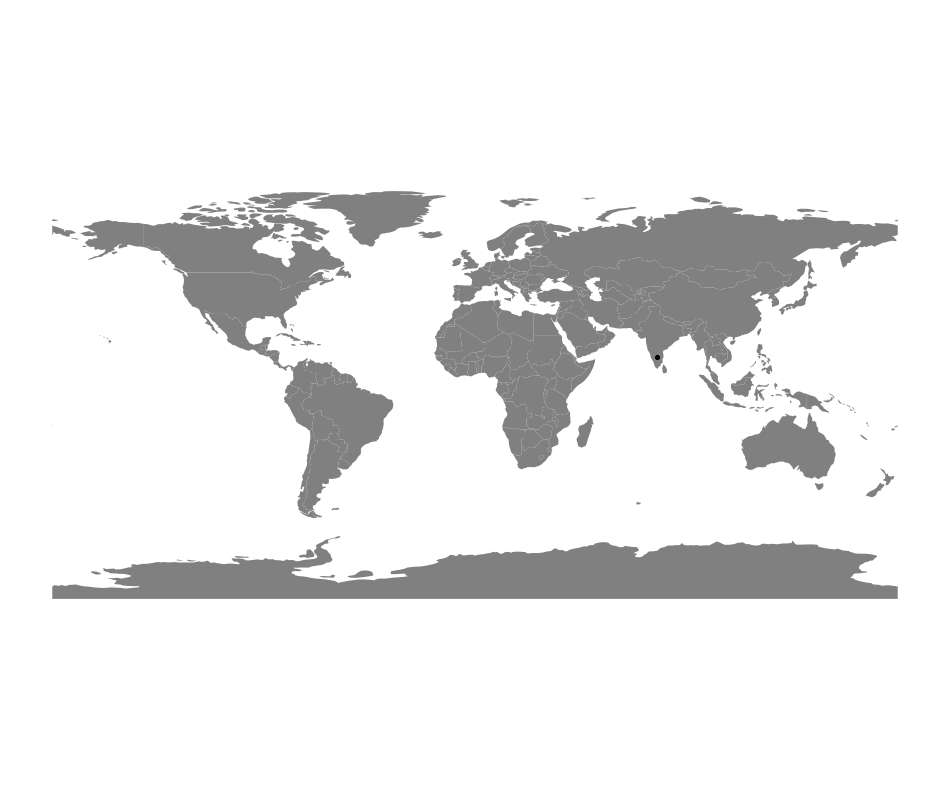

In [3]:
world: gpd.GeoDataFrame = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
fig, ax = plt.subplots(figsize=(12, 10))

world.plot(ax=ax, color="gray")
gdf.plot(ax=ax, markersize=3.5, color="black")
ax.axis("off")
plt.axis("equal")
plt.show()

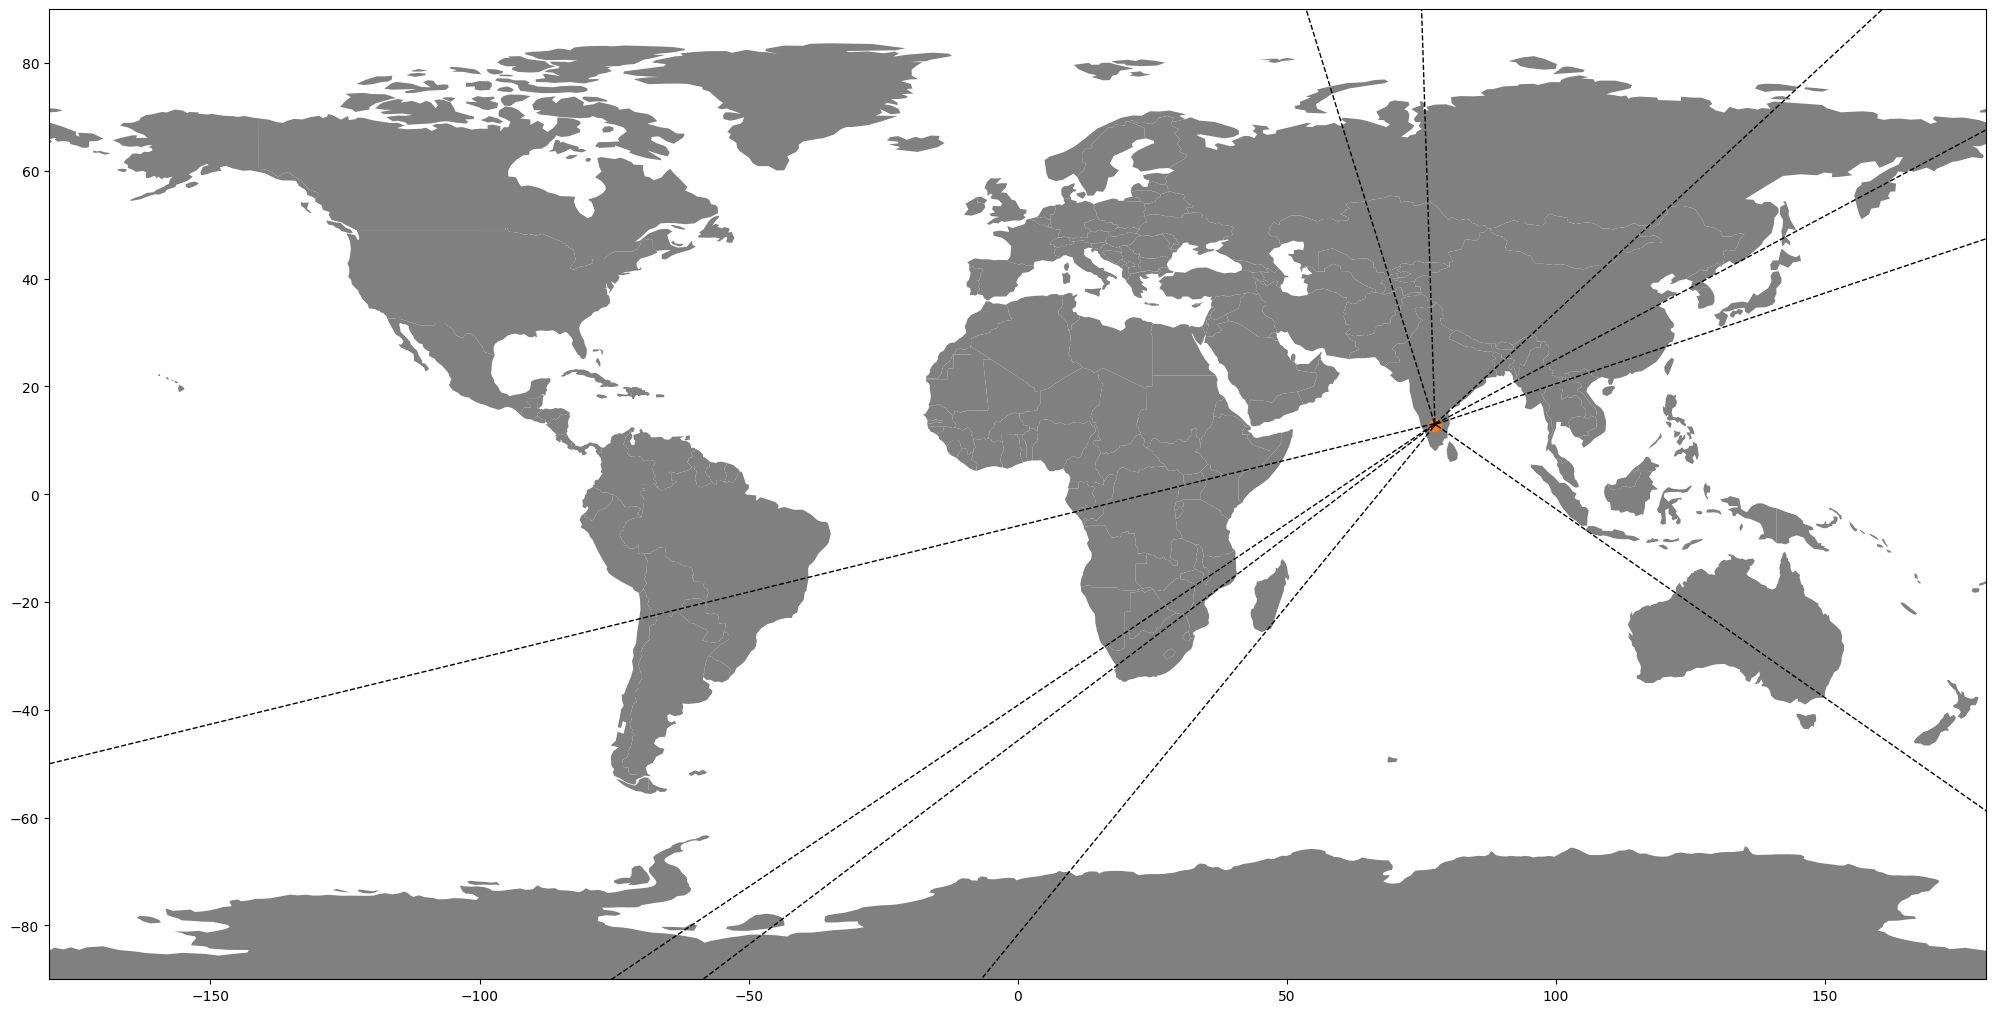

In [25]:
from matplotlib.axes import Axes
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d
# world_poly = Polygon([(-180, 90), (180, 90) , (180, -90), (-180, -90)])
# gdf_proj = gdf.to_crs(crs=3395)

boundary_shape = unary_union(world.geometry)
# boundary_shape = world_poly
coords = points_to_coords(gdf.geometry)
# coords = points_to_coords(gdf.set_crs(epsg=3995).geometry)

vor = Voronoi(coords, incremental=True)
fig, ax = plt.subplots(figsize=(25, 25))

def voronoi_plot_2d(vor: Voronoi, ax: Axes, **kw):
    from matplotlib.collections import LineCollection

    if vor.points.shape[1] != 2:
        raise ValueError("Voronoi diagram is not 2-D")

    if kw.get('show_points', True):
        point_size = kw.get('point_size', None)
        ax.plot(vor.points[:, 0], vor.points[:, 1], '.', markersize=point_size)
    if kw.get('show_vertices', True):
        ax.plot(vor.vertices[:, 0], vor.vertices[:, 1], 'o')

    line_colors = kw.get('line_colors', 'k')
    line_width = kw.get('line_width', 1.0)
    line_alpha = kw.get('line_alpha', 1.0)

    center = vor.points.mean(axis=0)
    ptp_bound = vor.points.ptp(axis=0)

    finite_segments = []
    infinite_segments = []
    for pointidx, simplex in zip(vor.ridge_points, vor.ridge_vertices):
        simplex = np.asarray(simplex)
        if np.all(simplex >= 0):
            finite_segments.append(vor.vertices[simplex])
        else:
            i = simplex[simplex >= 0][0]  # finite end Voronoi vertex

            t = vor.points[pointidx[1]] - vor.points[pointidx[0]]  # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[pointidx].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            if (vor.furthest_site):
                direction = -direction
            far_point = vor.vertices[i] + direction * 360

            infinite_segments.append([vor.vertices[i], far_point])

    ax.add_collection(LineCollection(finite_segments,
                                     colors=line_colors,
                                     lw=line_width,
                                     alpha=line_alpha,
                                     linestyle='solid'))
    ax.add_collection(LineCollection(infinite_segments,
                                     colors=line_colors,
                                     lw=line_width,
                                     alpha=line_alpha,
                                     linestyle='dashed'))

    return ax.figure

world.plot(ax=ax, color="gray")
voronoi_plot_2d(vor, ax)
# plt.xlim((76.5, 78.25))
# plt.ylim((12.25, 13.5))
plt.xlim((-180, 180))
plt.ylim((-90, 90))
plt.show()


# # Calculate Voronoi Regions
# region_polys, region_pts = voronoi_regions_from_coords(coords, boundary_shape)

# fig, ax = subplot_for_map()
# plot_voronoi_polys_with_points_in_area(ax, boundary_shape, region_polys, coords, region_pts)

# ax.set_title('Voronoi regions of Schools in Uppsala')
# plt.tight_layout()
# plt.show()



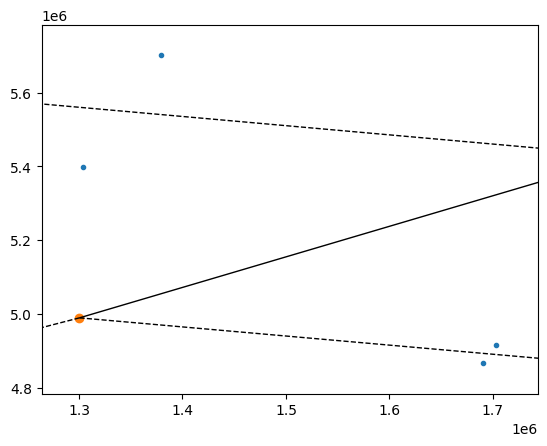

In [5]:
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from geovoronoi.plotting import subplot_for_map, plot_voronoi_polys_with_points_in_area
from geovoronoi import voronoi_regions_from_coords
from shapely.geometry import Point




coords = np.array([[1690891.43454513, 4865911.53550427],
       [1303898.2749075 , 5398659.4816214 ],
       [1379407.32051822, 5701267.51923313],
       [1703402.05850744, 4916559.63783754],
       ])

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
area = world[world.name == 'Italy']

area = area.to_crs(epsg=3395)    # convert to World Mercator CRS

area_shape = area.iloc[0].geometry   # get the Polygon


vor = Voronoi(coords)
fig = voronoi_plot_2d(vor)
plt.show()



# region_polys, region_pts = voronoi_regions_from_coords(coords, area_shape)

# fig, ax = subplot_for_map()
# plot_voronoi_polys_with_points_in_area(ax, area_shape, region_polys, coords, region_pts)
# plt.show()